# Установка и импорт библиотек

In [ ]:
!pip install pandas
!pip install numpy
!pip install joblib
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install imbalanced-learn
!pip install xgboost

In [363]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc

from imblearn.combine import SMOTETomek 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from imblearn.pipeline import Pipeline

import xgboost as xgb


# Обработка данных

Загружаем датафреймы и знакомимся с ними

In [364]:
tr = pd.read_csv('train.csv')
tst = pd.read_csv('valid.csv')

In [365]:
print(tr.shape)
print(tst.shape)

(14456, 2666)
(3642, 2666)


In [366]:
tst.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [367]:
tr.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


Смотрим пропуски в датафреймах

<Axes: >

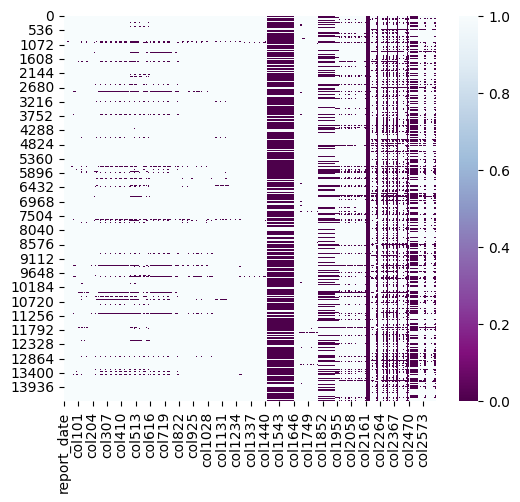

In [368]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr.isnull(), cmap='BuPu_r')

<Axes: >

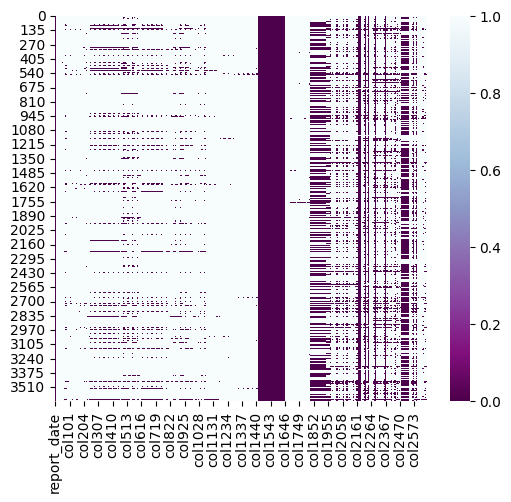

In [369]:
plt.figure(figsize=(6, 5))
sns.heatmap(tst.isnull(), cmap='BuPu_r')

Удаляем данные с большим количеством пропусков

In [370]:
threshold = 0.7
tr_c = tr.loc[:, tr.isnull().mean() < threshold]
threshold = 0.7
tr_c = tr_c[tr_c.isnull().mean(axis=1) < threshold]

In [371]:
threshold = 0.7
tst_c = tst.loc[:, tst.isnull().mean() < threshold]
threshold = 0.7
tst_c = tst_c[tst_c.isnull().mean(axis=1) < threshold]

In [372]:
print(tr_c.shape)
print(tst_c.shape)

(12885, 503)
(3640, 540)


In [373]:
# Подсчет количества непустых значений в каждой строке
tr_c['non_null_count'] = tr_c.apply(lambda row: row.count(), axis=1)

# Сортировка по количеству непустых значений в порядке убывания
tr_s = tr_c.sort_values(by='non_null_count', ascending=False)

# Оставляем только 5000 самых заполненных строк
tr_s = tr_s.head(5000)

# Удаляем временный столбец 'non_null_count'
tr_s = tr_s.drop(columns=['non_null_count'])

In [374]:
print(tr_s.shape)
print(tst_c.shape)

(5000, 503)
(3640, 540)


In [375]:
tr_s.head(5)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
6885,2023-01-01,5000,0,0,53872fd7-b5f6-ec11-b822-005056b8a6c4,0.0,0.0,0.0,0.0,0.0,...,360.0,360.0,360.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,0.258634
6793,2023-02-01,5879,0,0,02de0f50-bc5a-ed11-b822-005056b8a6c4,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,0.264647
5918,2022-05-01,474,1,0,1b2a9ad5-ede6-46be-b1a2-1186a40e156d,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,8126000.0,8126000.0,8126000.0,8126000.0,8126000.0,8126000.0,0.265912
8723,2023-02-01,6636,0,0,c24175f0-b259-ed11-b823-005056b8a72c,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,0.260853
2972,2023-01-01,3491,0,0,210b9249-abf6-ec11-b822-005056b8a6c4,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,0.258007


In [376]:
tst_c.head(5)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,0,01016bd5-10dc-ec11-b823-005056b825cd,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,0,0151dccf-0ecb-ed11-b828-005056b81dee,0.0,0.0,1.0,1.0,1.0,...,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,0,074ce8a6-859a-4084-a1c6-41343a94a856,0.0,0.0,0.0,0.0,0.0,...,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,0,08e72a9b-74fd-450a-982e-a8cede3facb3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,0,0a033230-3889-4239-8900-0ffb7e48958c,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0,0.257348


Снова смотрим на пропуски, уже лучше

<Axes: >

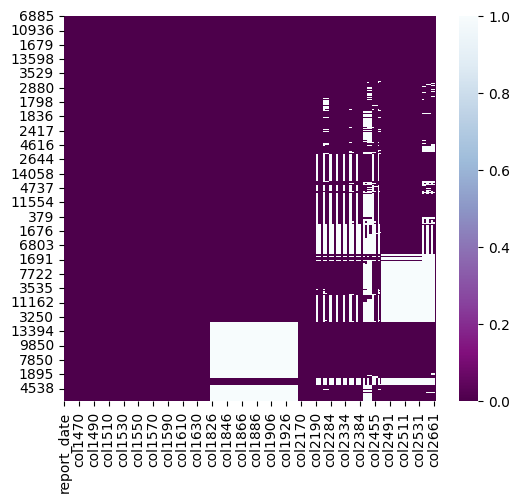

In [377]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr_s.isnull(), cmap='BuPu_r')

<Axes: >

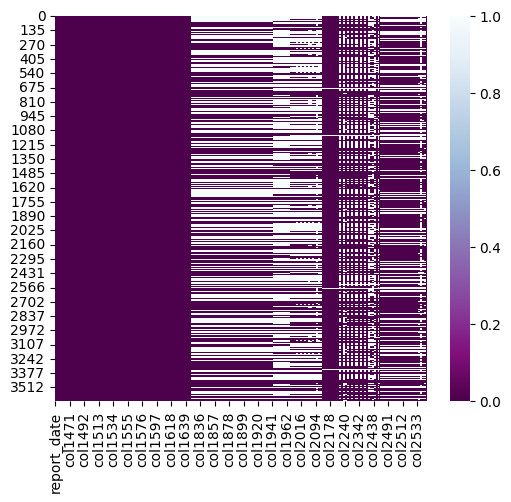

In [378]:
plt.figure(figsize=(6, 5))
sns.heatmap(tst_c.isnull(), cmap='BuPu_r')

Удаляем дубликаты строк (исключая столбцы report_date и target), а также заполняем пропущенные значения. 

In [379]:
columns1 = tr_s.select_dtypes('object').columns
numeric_columns = tr_s.select_dtypes(include=['float']).columns
tr_s = tr_s.drop_duplicates(subset=list(set(tr_s.columns) - set(['report_date', 'target'])))

# Заполняем пропущенные значения в категориальных переменных
for col in columns1:
    tr_s[col] = tr_s[col].fillna("unknown")

# Заполняем пропущенные значения в числовых переменных
for num_col in numeric_columns:
    mean_value = tr_s[num_col].mean()
    tr_s[num_col] = tr_s[num_col].fillna(int(mean_value))

tr_s = tr_s.apply(lambda x:x.fillna(0))

In [380]:
columns1 = tst_c.select_dtypes('object').columns
numeric_columns = tst_c.select_dtypes(include=['float']).columns
tst_c = tst_c.drop_duplicates(subset=list(set(tst_c.columns) - set(['report_date', 'target'])))

# Заполняем пропущенные значения в категориальных переменных
for col in columns1:
    tst_c[col] = tst_c[col].fillna("unknown")

# Заполняем пропущенные значения в числовых переменных
for num_col in numeric_columns:
    mean_value = tst_c[num_col].mean()
    tst_c[num_col] = tst_c[num_col].fillna(int(mean_value))

tst_s = tst_c.apply(lambda x:x.fillna(0))

In [381]:
def del_duble(tr_s):
  unique_columns = []
  for column in tr_s.columns:
    if not any(tr_s[column].equals(tr_s[col]) for col in unique_columns):
      unique_columns.append(column)
  return tr_s[unique_columns]

tr_s = del_duble(tr_s)
print(tr_s.shape)

(4995, 271)


In [382]:
def del_duble(tst_s):
  unique_columns = []
  for column in tst_s.columns:
    if not any(tst_s[column].equals(tst_s[col]) for col in unique_columns):
      unique_columns.append(column)
  return tst_s[unique_columns]

tst_s = del_duble(tst_s)
print(tst_s.shape)

(3630, 290)


Теперь пропусков нет!

<Axes: >

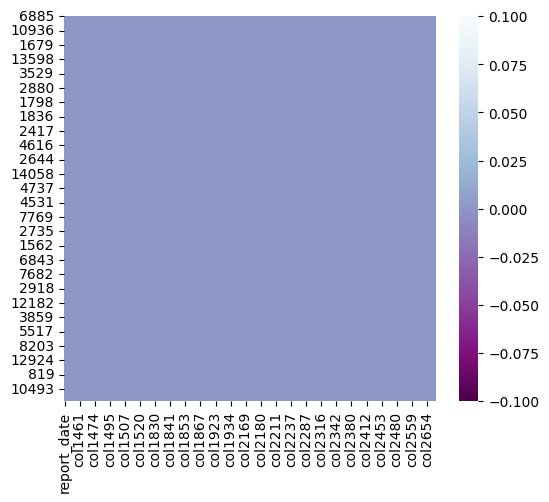

In [383]:
plt.figure(figsize=(6, 5))
sns.heatmap(tr_s.isnull(), cmap='BuPu_r')

<Axes: >

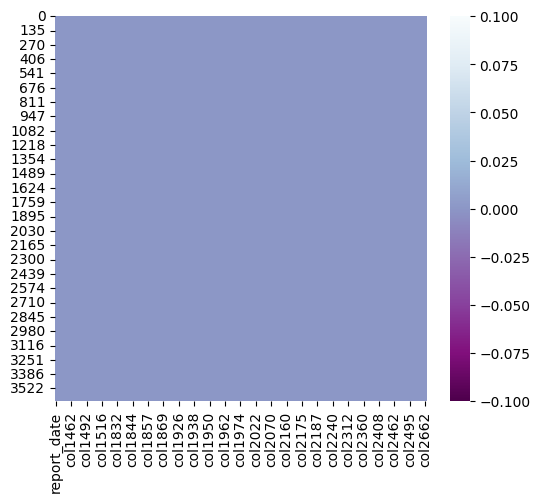

In [384]:
plt.figure(figsize=(6, 5))
sns.heatmap(tst_s.isnull(), cmap='BuPu_r')

Посмотрим нечисловые столбцы, узнаем что они делают

In [385]:
non_numeric_columns = tr_s.select_dtypes(exclude=['number'])
print("Нечисловые столбцы трейн:")
print(non_numeric_columns)
non_numeric_columns = tst_s.select_dtypes(exclude=['number'])
print("Нечисловые столбцы тест:")
print(non_numeric_columns)

Нечисловые столбцы трейн:
      report_date                               col1454
6885   2023-01-01  53872fd7-b5f6-ec11-b822-005056b8a6c4
6793   2023-02-01  02de0f50-bc5a-ed11-b822-005056b8a6c4
5918   2022-05-01  1b2a9ad5-ede6-46be-b1a2-1186a40e156d
8723   2023-02-01  c24175f0-b259-ed11-b823-005056b8a72c
2972   2023-01-01  210b9249-abf6-ec11-b822-005056b8a6c4
...           ...                                   ...
12812  2022-05-01  6c851050-8025-4a3e-9cec-604b380bced3
11429  2022-04-01  7e456615-f4d1-49fe-998e-1140e14188d4
13372  2022-04-01  6200165e-24cf-47b8-adb8-0f88311ceba9
5117   2022-06-01  59e6b55b-2ce7-40d6-b6ca-42a966c02855
3631   2022-03-01  5b494ce5-88b4-40ce-84ef-1a74147dd6f8

[4995 rows x 2 columns]
Нечисловые столбцы тест:
     report_date                               col1454
0     2023-04-01  01016bd5-10dc-ec11-b823-005056b825cd
1     2023-05-01  0151dccf-0ecb-ed11-b828-005056b81dee
2     2023-05-01  074ce8a6-859a-4084-a1c6-41343a94a856
3     2023-03-01  08e72a9b-74fd-

Посмотрим для двух клиентов отдельно

In [386]:
tr_client1 = tr_s[tr_s['client_id'] == 888]
tr_client2 = tr_s[tr_s['client_id'] == 777]

In [387]:
tr_client1

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
7617,2023-01-01,888,0,0,1248166f-158a-45fb-8bfa-48685c406363,0.0,0.0,0.0,0.0,0.0,...,287.0,283.0,285.0,7459672.0,7311909.0,7384674.0,7489728.0,7296713.0,7390735.0,0.257217
596,2022-12-01,888,0,0,1248166f-158a-45fb-8bfa-48685c406363,0.0,0.0,0.0,0.0,0.0,...,287.0,283.0,285.0,7459672.0,7311909.0,7384674.0,7489728.0,7296713.0,7390735.0,0.257217
2650,2022-09-01,888,0,0,1248166f-158a-45fb-8bfa-48685c406363,0.0,0.0,0.0,0.0,0.0,...,287.0,283.0,285.0,7459672.0,7311909.0,7384674.0,7489728.0,7296713.0,7390735.0,0.257217


In [388]:
tr_client2

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
525,2022-11-01,777,0,0,d917d6af-1ab4-ec11-b823-005056b8a72c,0.0,0.0,0.0,0.0,0.0,...,300.0,300.0,300.0,7459672.0,7311909.0,7384674.0,7489728.0,7296713.0,7390735.0,0.25677
3770,2022-08-01,777,0,0,d917d6af-1ab4-ec11-b823-005056b8a72c,0.0,0.0,0.0,0.0,2.0,...,300.0,300.0,300.0,7459672.0,7311909.0,7384674.0,7489728.0,7296713.0,7390735.0,0.25677


Колонка "col1454" одинакова для одного client_id. Значит спокойно удаляем ее, также удаляем "report_date" она помешает в дальнейшем.

In [389]:
tst_s.drop(['report_date'], axis = 1, inplace = True)
tst_s.drop(['col1454'], axis = 1, inplace = True)
tst_s.drop(['col2663'], axis = 1, inplace = True)
tr_s.drop(['report_date'], axis = 1, inplace = True)
tr_s.drop(['col1454'], axis = 1, inplace = True)
tr_s.drop(['col2663'], axis = 1, inplace = True)

In [390]:
print("Количество пропущенных значений в трейне:")
print(tr_s.isnull().sum())
print("Количество пропущенных значений в тесте:")
print(tst_s.isnull().sum())

Количество пропущенных значений в трейне:
client_id    0
target       0
col1453      0
col1455      0
col1456      0
            ..
col2655      0
col2656      0
col2660      0
col2661      0
col2662      0
Length: 268, dtype: int64
Количество пропущенных значений в тесте:
client_id    0
target       0
col1453      0
col1455      0
col1456      0
            ..
col2589      0
col2590      0
col2660      0
col2661      0
col2662      0
Length: 287, dtype: int64


Посмотрим на матрицы корреляции 

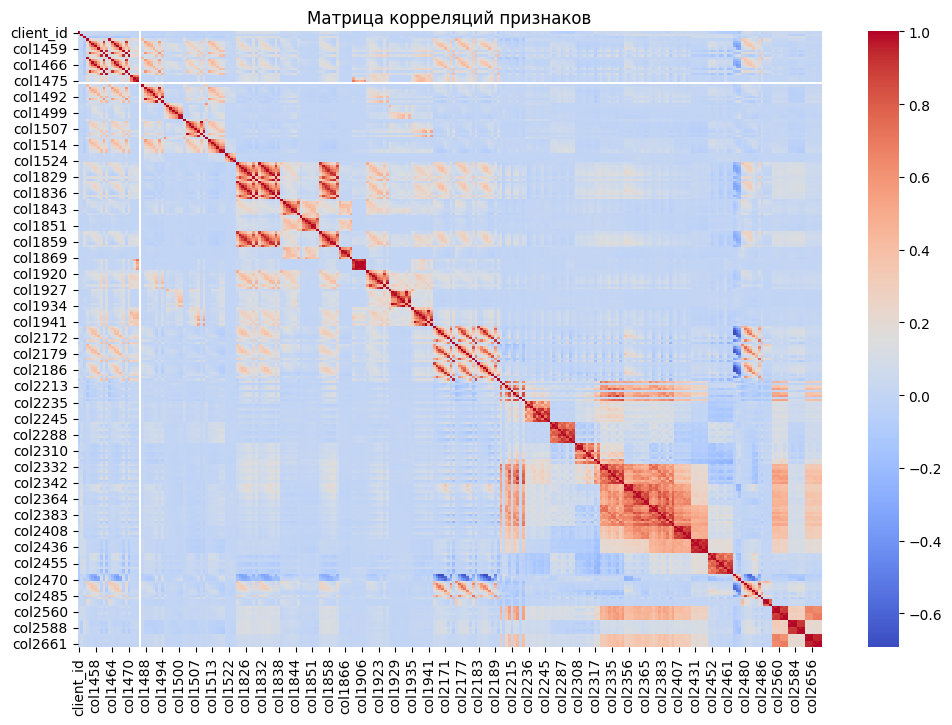

In [391]:
# Анализ корреляций
correlation_matrix = tr_s.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций признаков')
plt.show()

Удаляем колонки которые не могут быть коррелированы

In [392]:
print(tr_s['col1474'].value_counts())
print(tr_s['col1475'].value_counts())
print(tr_s['col1479'].value_counts())
print(tst_s['col1470'].value_counts())
print(tst_s['col1471'].value_counts())

col1474
0.0    4993
2.0       2
Name: count, dtype: int64
col1475
0.0    4992
2.0       2
1.0       1
Name: count, dtype: int64
col1479
0.0    4995
Name: count, dtype: int64
col1470
1.0     2312
2.0      851
3.0      273
4.0      107
5.0       44
6.0       14
8.0        6
7.0        5
13.0       4
16.0       4
9.0        4
12.0       2
11.0       1
10.0       1
18.0       1
20.0       1
Name: count, dtype: int64
col1471
0.0    3630
Name: count, dtype: int64


In [393]:
tst_s.drop(['col1470'], axis = 1, inplace = True)
tst_s.drop(['col1471'], axis = 1, inplace = True)
tr_s.drop(['col1474'], axis = 1, inplace = True)
tr_s.drop(['col1475'], axis = 1, inplace = True)
tr_s.drop(['col1479'], axis = 1, inplace = True)

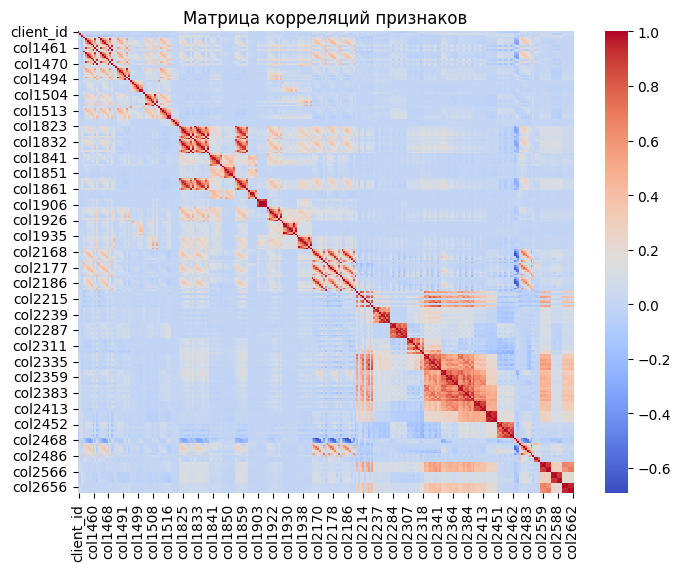

In [394]:
# Анализ корреляций
correlation_matrix = tr_s.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций признаков')
plt.show()

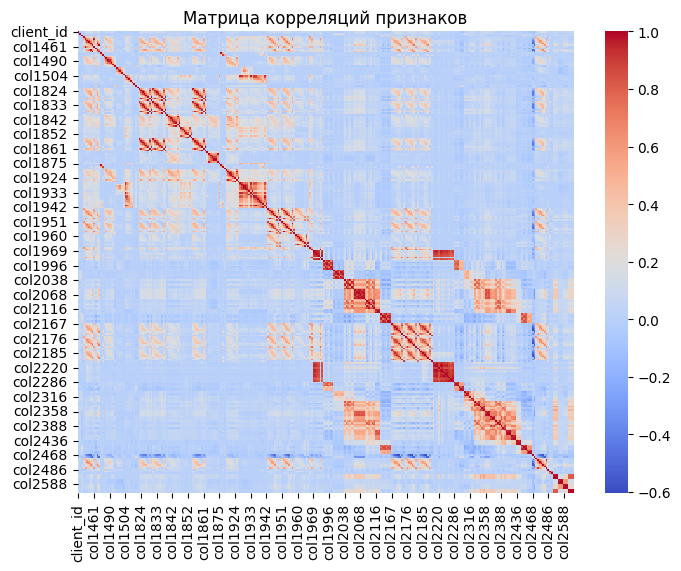

In [395]:
# Анализ корреляций
correlation_matrix = tst_s.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций признаков')
plt.show()

Готово, данные прошли первичную обработку.

______________________

# Модель №1 LogisticRegression

In [396]:
#  # Удаление столбца client_id
#  tr_s = tr_s.drop('client_id', axis=1)
#  tst_s = tst_s.drop('client_id', axis=1)

Оставляем только те колонки в валидационном датасете, которые есть в обучающем

In [397]:

tst_s = tr_s[tr_s.columns.intersection(tr_s.columns)]
missing_columns = set(tr_s.columns) - set(tst_s.columns)

for col in missing_columns:
    tst_s[col] = 0  # Или другое значение, например, среднее/медиану по обучающему набору

# Приводим порядок колонок к обучающему набору
tst_s = tst_s[tr_s.columns]

In [398]:
print(tr_s.shape)
print(tst_s.shape)

(4995, 265)
(4995, 265)


Строим Модель LogisticRegression

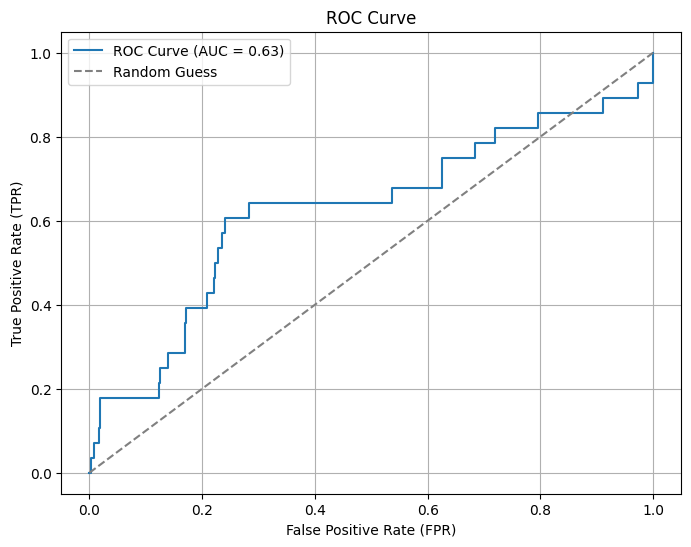

In [399]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = tr_s.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = tr_s['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model1 = LogisticRegression(class_weight="balanced", random_state=101, max_iter=1000)
model1.fit(X_train, y_train)

# Предсказание вероятностей для тестовой выборки
y_pred_proba = model1.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Вычисление AUC (Area Under Curve)
auc1 = roc_auc_score(y_test, y_pred_proba)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc1:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Предсказание на valid

Accuracy on validation set: 0.7341341341341341
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      4830
           1       0.08      0.65      0.14       165

    accuracy                           0.73      4995
   macro avg       0.53      0.70      0.49      4995
weighted avg       0.95      0.73      0.82      4995

ROC AUC on validation set: 0.733845285149633


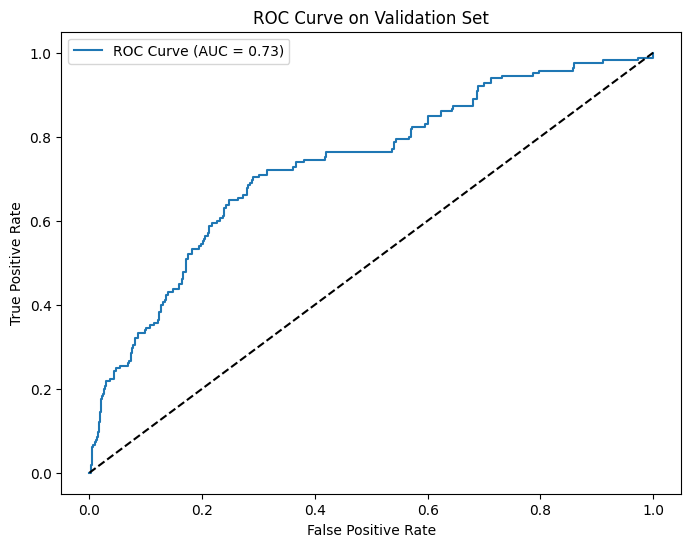

In [400]:
# Прогнозирование на валидационной выборке
X_valid = tst_s.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = tst_s['target']

y_valid_pred = model1.predict(X_valid)
y_valid_pred_proba = model1.predict_proba(X_valid)[:, 1]

# Оценка качества модели на валидационной выборке
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f'Accuracy on validation set: {accuracy_valid}')

print(classification_report(y_valid, y_valid_pred))

roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print(f'ROC AUC on validation set: {roc_auc_valid}')

# Визуализация ROC-кривой на валидационной выборке
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.show()

# Модель №2 RandomForest

In [401]:
# Разделение данных
X = tr_s.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = tr_s['target']

# Разделение данных на обучающую и тестовую выборки с учетом баланса классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Определение категориальных столбцов
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Кодирование категориальных переменных
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns].astype(str))
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns].astype(str))

# Создание модели 
random_forest_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features='sqrt',  
    bootstrap=True,
    oob_score=True
)

# Создание пайплайна с балансировкой классов и моделью
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)),  # Балансировка классов
    ('rf', random_forest_model)
])

# Определение гиперпараметров для поиска
param_distributions = {
    'rf__n_estimators': [50, 75, 100], 
    'rf__max_depth': [3, 4, 5],         
    'rf__min_samples_split': [30, 40, 50], 
    'rf__min_samples_leaf': [20, 30, 40],   
    'rf__class_weight': ['balanced']        
}

# Поиск лучших гиперпараметров с использованием RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

# Обучение модели 
random_search.fit(X_train, y_train)

# Оценка на тестовых данных
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Вывод результатов
print("Лучшие параметры модели:", random_search.best_params_)
print("\nROC-AUC на тестовых данных:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report на тестовых данных:\n", classification_report(y_test, best_model.predict(X_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'rf__n_estimators': 100, 'rf__min_samples_split': 30, 'rf__min_samples_leaf': 40, 'rf__max_depth': 5, 'rf__class_weight': 'balanced'}

ROC-AUC на тестовых данных: 0.7534192860279817

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93       966
           1       0.11      0.42      0.17        33

    accuracy                           0.87       999
   macro avg       0.54      0.65      0.55       999
weighted avg       0.95      0.87      0.90       999



Сохраняем данные, потому что это лучшая модель из 3

In [402]:
# Сохранение результатов
submission = pd.DataFrame({'client_id': tr_s.loc[X_test.index, 'client_id'], 'score': y_pred_proba})
submission.to_csv('submission.csv', index=False)

Предсказание на valid


ROC-AUC на valid данных: 0.8612980739067696

Classification Report на valid данных:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      4830
           1       0.15      0.58      0.24       165

    accuracy                           0.88      4995
   macro avg       0.57      0.73      0.59      4995
weighted avg       0.96      0.88      0.91      4995



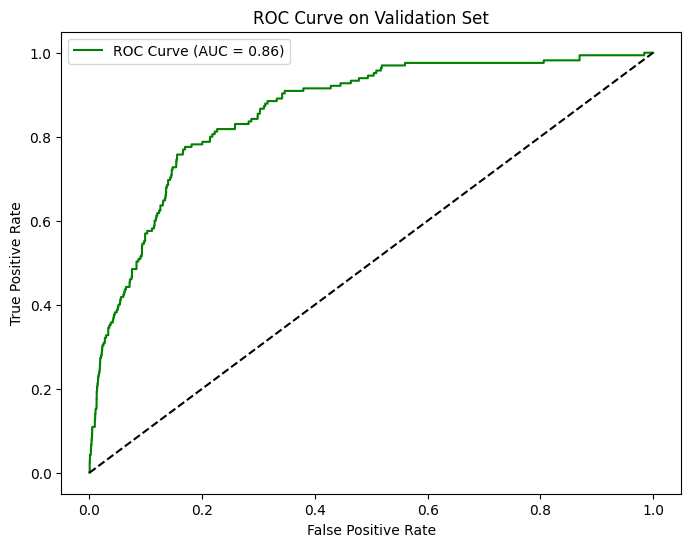

In [403]:

X_valid = tst_s.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = tst_s['target']

# Кодирование категориальных признаков
X_valid[categorical_columns] = ordinal_encoder.transform(X_valid[categorical_columns].astype(str))

# Предсказание на valid_no_duplicates
y_valid_pred = best_model.predict(X_valid)
y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Оценка модели на valid
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("\nROC-AUC на valid данных:", roc_auc_valid)
print("\nClassification Report на valid данных:\n", classification_report(y_valid, y_valid_pred))

# Визуализация ROC-AUC
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
roc_auc_valid_curve = auc(fpr_valid, tpr_valid)

# Визуализация ROC-кривой на валидационной выборке
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.show()

# Модель №3 XGBoost

Балансируем данные по target. (Делаем так, чтобы 0 было столько же, сколько и 1)

In [404]:
df_ones = tst_s[tst_s['target'] == 1]

df_zeros = tst_s[tst_s['target'] == 0].head(66)

filtered_df = pd.concat([df_zeros, df_ones])

valid_df = filtered_df.reset_index(drop=True)
valid_df

,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,col1461,...,col2584,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662
0,5000,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,360.0,360.0,360.0,360.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0
1,5879,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,360.0,360.0,360.0,360.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0
2,6636,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,360.0,360.0,360.0,360.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0
3,3491,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,240.0,240.0,240.0,240.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0
4,6232,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,360.0,360.0,360.0,360.0,8419200.0,8419200.0,8419200.0,8419200.0,8419200.0,8419200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,4246,1,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,242.0,242.0,242.0,242.0,8000000.0,8000000.0,8000000.0,8000000.0,8000000.0,8000000.0
227,1049,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,180.0,180.0,180.0,180.0,13199998.0,13199998.0,13199998.0,13199998.0,13199998.0,13199998.0
228,6089,1,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,242.0,242.0,242.0,242.0,8370000.0,8370000.0,8370000.0,8370000.0,8370000.0,8370000.0
229,2422,1,0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,...,240.0,240.0,240.0,240.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0


Строим модель XGBoost

In [405]:
X_train = tr_s.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_train = tr_s['target']

X_val = valid_df.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_val = valid_df['target']
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,  # Увеличиваем глубину деревьев
    'learning_rate': 0.1,  # Уменьшаем скорость обучения
    'n_estimators': 100,  # Большее количество итераций
    'subsample': 0.6,  # Используем только часть данных на каждой итерации
    'colsample_bytree': 0.8,  # Используем часть признаков
    'gamma': 1,  # Добавляем регуляризацию
    'random_state': 1
}

In [406]:
model3 = xgb.train(params, dtrain, num_boost_round=100)

Предсказание на valid

In [407]:
y_prob = model3.predict(dval)

fpr, tpr, trashers = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

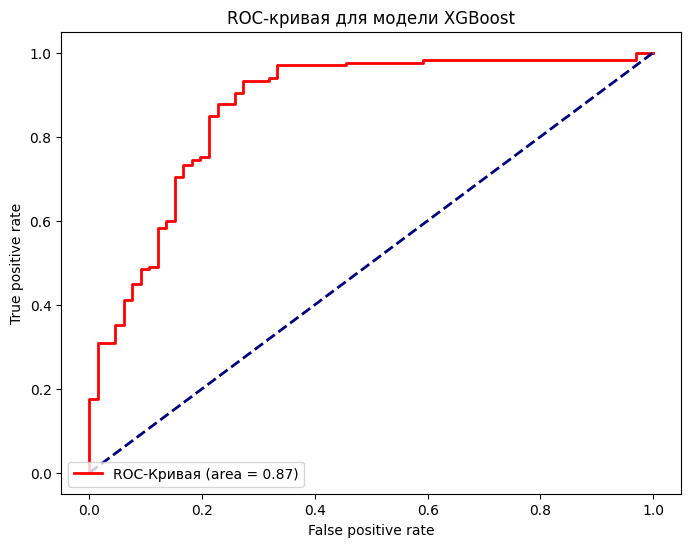

In [408]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC-Кривая (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-кривая для модели XGBoost')
plt.legend(loc='lower left')
plt.show()

__________________________________

# Вывод

В рамках данной работы были разработаны три модели машинного обучения, которые позволяют прогнозировать вероятность покупки клиентами машиномест в паркинге. Лучшей из них оказалась RandomForest. Основным результатом является "score" для каждого клиента, отражающий вероятность того, что клиент приобретет машиноместо.

Результаты:
- Модель успешно прогнозирует вероятность покупки машиноместа для каждого клиента.

- Метрика ROC-AUC демонстрирует высокое качество модели, что подтверждает её эффективность в выделении потенциальных покупателей.
